# DataLab Cup 4 : Unlearnable Dataset
`Neural Tangent Generalization Attacks (NTGA)`

# Dataset Download
CAUTION: If you nerver download dataset from Kaggle before, plz follow the tutorial in this page: https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/

In [ ]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-cifar-10

In [ ]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-imagenet

## CIFAR-10

In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-cifar-10.zip'
zip_list(file_path)

## Imagenet

In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-imagenet.zip'
zip_list(file_path)

# Libraries and Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

from tqdm import tqdm

import re
from IPython import display

In [2]:
!nvidia-smi

Tue Jan 11 23:07:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   46C    P0    52W / 250W |     14MiB /  8119MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Hyperparameter

In [4]:
# MODE = 'cifar10'
MODE = 'imagenet'
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_CLASSES = 2
LR = 0.001

# Dataset

In [5]:
x_train = np.load(f'./dataset/x_train_{MODE}_unlearn.npy')
y_train = np.load(f'./dataset/y_train_{MODE}.npy')
x_val = np.load(f'./dataset/x_val_{MODE}.npy')
y_val = np.load(f'./dataset/y_val_{MODE}.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [6]:
def vertical_flip(tf_img, label):
    return tf.image.flip_left_right(tf_img), label

def horizontal_flip(tf_img, label):
    return tf.image.flip_up_down(tf_img), label

def dataset_generator(data , label, training=True, drop_remainder=True):
    temp_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    if(training):
        # normalized_dataset = temp_dataset.map(normalization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        vertical_dataset = temp_dataset.map(vertical_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        horizontal_dataset = temp_dataset.map(horizontal_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = temp_dataset.concatenate(vertical_dataset)
        dataset = dataset.concatenate(horizontal_dataset)
        dataset = dataset.shuffle(len(data))
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=drop_remainder)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    else:
        # normalized_dataset = temp_dataset.map(normalization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = temp_dataset.batch(BATCH_SIZE, drop_remainder=drop_remainder)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset


batched_dataset = dataset_generator(x_train, y_train, training=True, drop_remainder=True)
batched_val_dataset = dataset_generator(x_val, y_val, training=False, drop_remainder=True)

2022-01-11 23:07:26.088214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1336688640 exceeds 10% of free system memory.
2022-01-11 23:07:26.767516: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1336688640 exceeds 10% of free system memory.


In [7]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# normalized_dataset = train_dataset.map(normalization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# vertical_dataset = normalized_dataset.map(vertical_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# horizontal_dataset = normalized_dataset.map(horizontal_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# normalized_dataset = normalized_dataset.concatenate(vertical_dataset)
# normalized_dataset = normalized_dataset.concatenate(horizontal_dataset)
# dataset = normalized_dataset.shuffle(len(x_train))
# batched_dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
# # batched_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# # batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# normalized_dataset = val_dataset.map(normalization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# batched_val_dataset = normalized_dataset.batch(BATCH_SIZE, drop_remainder=True)
# # batched_val_dataset = batched_val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# # batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [8]:
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# batched_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [9]:
def show_image(dataset):
    fig = plt.figure(figsize=(21,21))
    num_pic = 5
    plt.subplot(1,num_pic,1)
    for data in dataset.take(1):
        for idx in range(num_pic):
            plt.subplot(1, num_pic, idx+1)
            plt.imshow(data[0][idx])
            plt.axis('off')

2022-01-11 23:07:30.643348: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1336688640 exceeds 10% of free system memory.
2022-01-11 23:07:31.236730: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1336688640 exceeds 10% of free system memory.
2022-01-11 23:07:31.828626: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1336688640 exceeds 10% of free system memory.
/tmp/ipykernel_657790/3166481625.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, num_pic, idx+1)


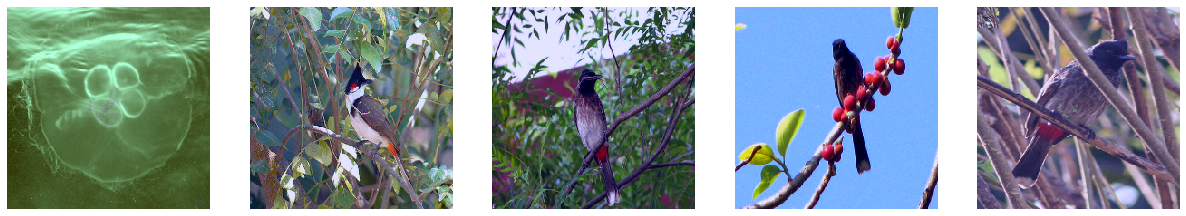

In [10]:
show_image(batched_dataset)

# Model

In [11]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [17]:
# DenseNet121
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
densenet121 = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights=None ,classes=NUM_CLASSES)
# densenet121.trainable = True

inputs = keras.Input(shape=input_shape)
x = densenet121(inputs)
x = conv_leaky_relu(x, 128, 3, 1)
x = conv_leaky_relu(x, 128, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(NUM_CLASSES)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
model.summary()

Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         1179776   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              

# Training

In [22]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [23]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset, epochs=50)

Epoch 1/50
208/208 [==============================] - 65s 284ms/step - loss: 2.0525 - acc: 0.9049 - val_loss: 565.7057 - val_acc: 0.4602
Epoch 2/50
208/208 [==============================] - 58s 280ms/step - loss: 0.1020 - acc: 0.9694 - val_loss: 3.7399 - val_acc: 0.6222
Epoch 3/50
208/208 [==============================] - 58s 280ms/step - loss: 0.5471 - acc: 0.9309 - val_loss: 9.5092 - val_acc: 0.6364
Epoch 4/50
208/208 [==============================] - 58s 280ms/step - loss: 0.0919 - acc: 0.9734 - val_loss: 3.8039 - val_acc: 0.5909
Epoch 5/50
208/208 [==============================] - 58s 280ms/step - loss: 0.0511 - acc: 0.9851 - val_loss: 2.6315 - val_acc: 0.5795
Epoch 6/50
208/208 [==============================] - 58s 280ms/step - loss: 0.0622 - acc: 0.9841 - val_loss: 2.5535 - val_acc: 0.7642
Epoch 7/50
208/208 [==============================] - 58s 280ms/step - loss: 0.0261 - acc: 0.9926 - val_loss: 1.3615 - val_acc: 0.6705
Epoch 8/50
208/208 [==============================] -

# Visualize

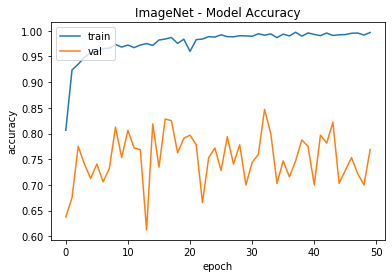

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ImageNet - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation - Testing dataset

In [37]:
x_test = np.load('./dataset/x_test_imagenet.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
batched_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [38]:
predict_output = model.predict(x=batched_test_dataset)
final_output = np.argmax(predict_output, axis=1)

In [39]:
if not os.path.exists('output'):
    os.makedirs('output')

output = pd.DataFrame({'id':range(len(final_output)), 'label':final_output})
output.to_csv('./output/submission.csv', header=True, index=False)